## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

## Import Data

In [2]:
df = pd.read_excel('premiums.xlsx')

print(f'The number of Rows is {df.shape[0]}')
print(f'The number of Cols is {df.shape[1]}')

The number of Rows is 50000
The number of Cols is 13


In [3]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

## Data Cleaning

### Handle NA values

In [5]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(49976, 13)

In [8]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicates

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Handle outliers

In [11]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


#### Handle Outliers : number_of_dependants

In [12]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1])

In [13]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

#### Handle Outliers : numerical columns

In [14]:
numerical_cols = df.select_dtypes(['float64', 'int64']).columns
numerical_cols

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [15]:
def boxPlots(data, cols):
    for col in cols:
        sns.boxplot(data, x=col)
        plt.show()

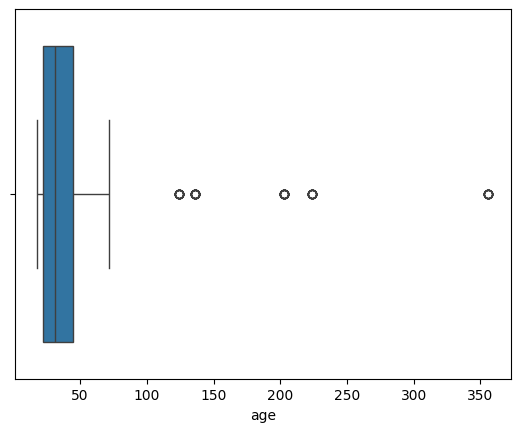

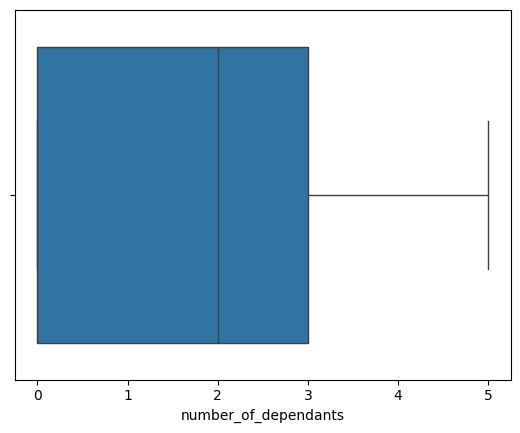

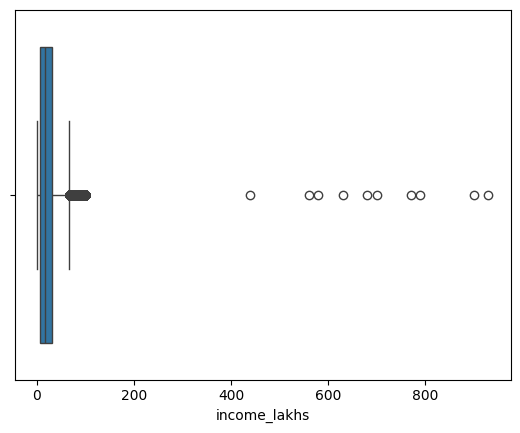

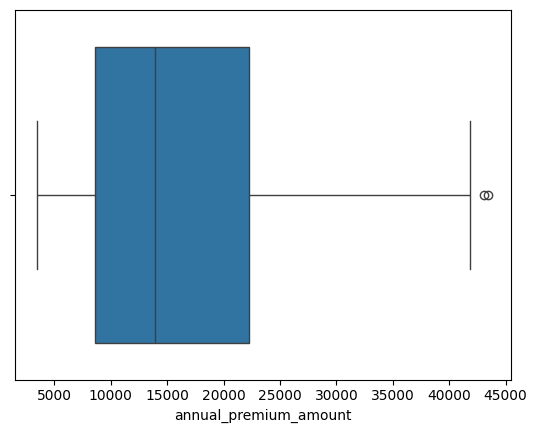

In [16]:
boxPlots(df, numerical_cols)

##### Handle Outliers : numerical columns (age)

In [17]:
df[df.age > 100].shape

(58, 13)

In [18]:
df1 = df[df.age < 100].copy()

In [19]:
df1.shape

(49918, 13)

In [20]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


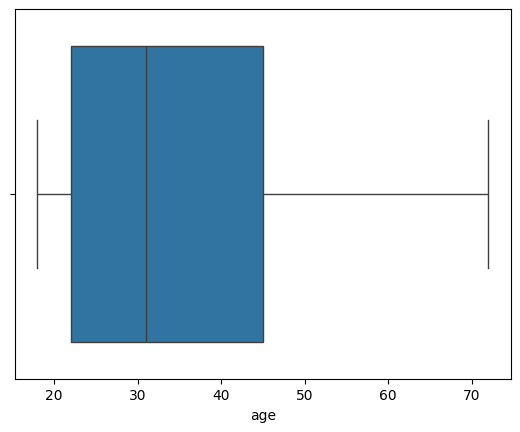

In [21]:
boxPlots(df1, ['age'])

##### Handle Outliers : numerical columns (income_lakhs)

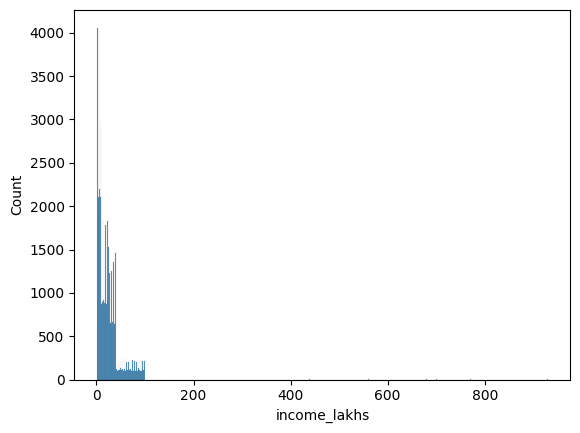

In [22]:
sns.histplot(df1, x='income_lakhs')
plt.show()

In [23]:
def get_iqr_bounds(col):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [24]:
lower_bound, upper_bound = get_iqr_bounds(df1['income_lakhs'])
lower_bound, upper_bound

(-29.0, 67.0)

In [25]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [26]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.shape

(49908, 13)

In [27]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


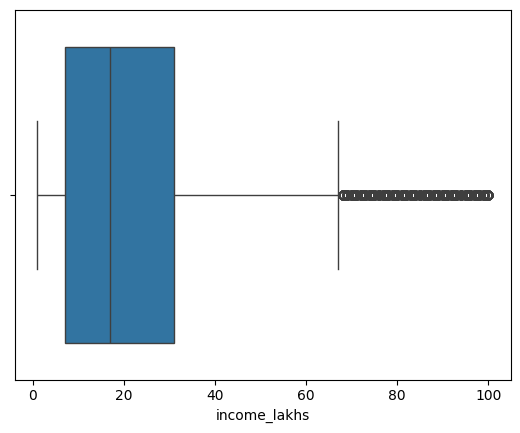

In [28]:
boxPlots(df2, ['income_lakhs'])

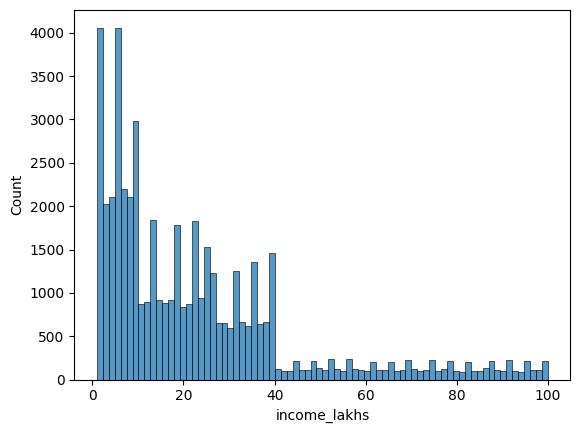

In [29]:
sns.histplot(df2, x='income_lakhs')
plt.show()

## Data Analysis

### Data Analysis : numerical columns

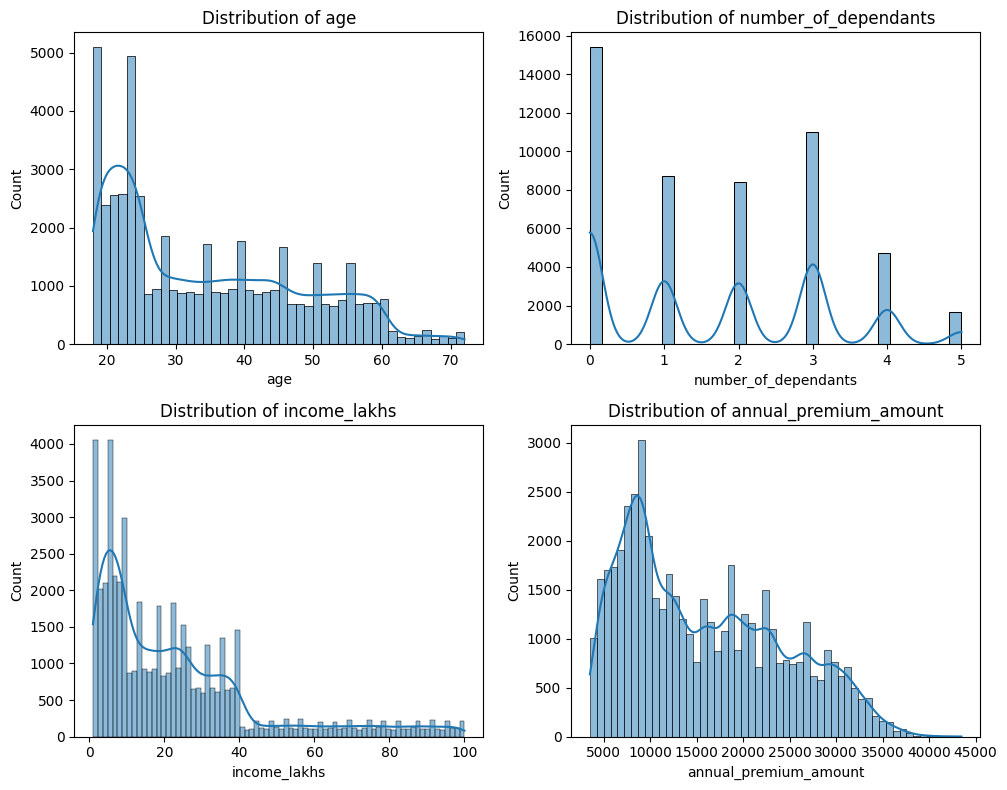

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid

for ax, col in zip(axes.flatten(), numerical_cols[:4]):  # [:4] just in case you have more than 4
    sns.histplot(df2, x=col, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

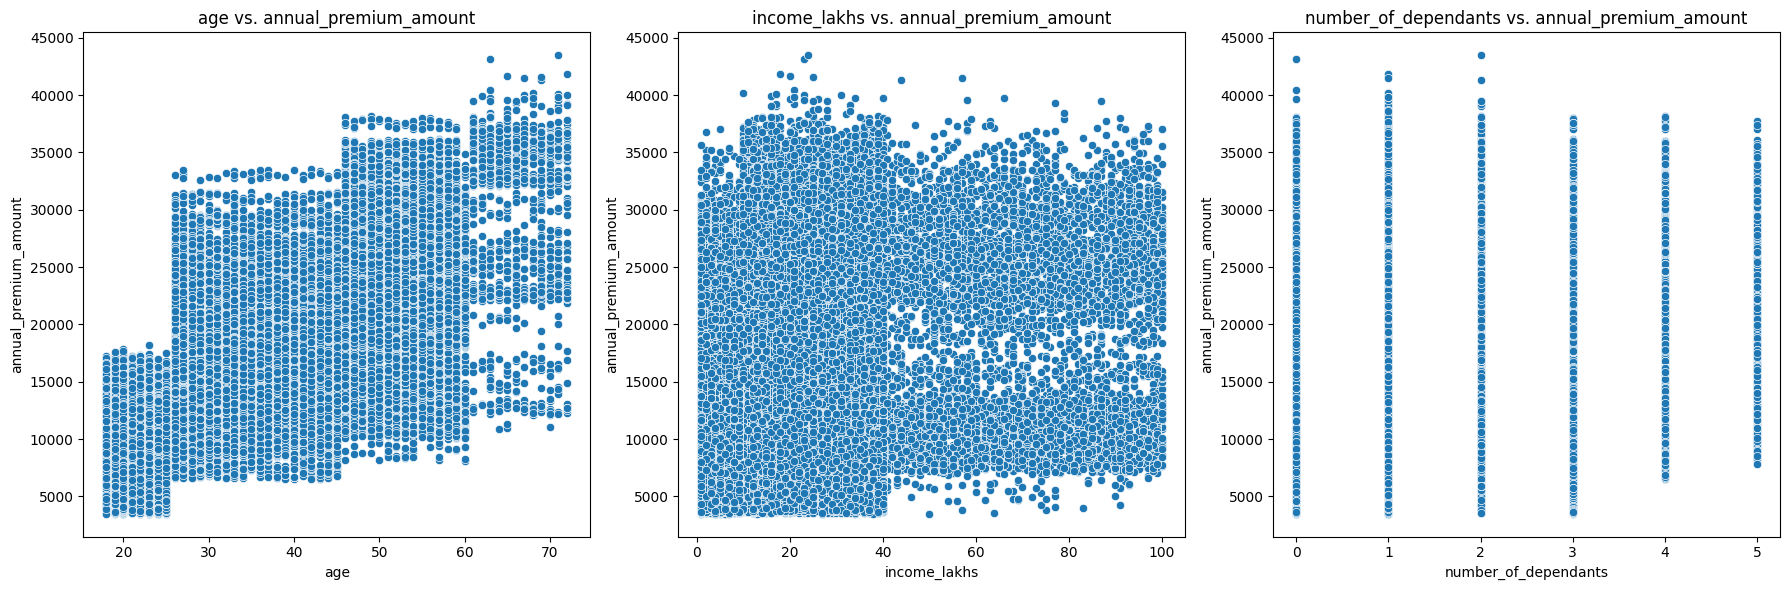

In [31]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']
target = 'annual_premium_amount'

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # 2x2 grid

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col], y=df2[target], ax=ax)
    ax.set_title(f'{col} vs. {target}')
    ax.set_xlabel(col)
    ax.set_ylabel(target)

plt.tight_layout()
plt.show()

### Data Analysis : Categorical columns

In [32]:
df2.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [33]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']

categorical_cols

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [34]:
for col in categorical_cols:
    print(f' {col} : {df2[col].unique()}')

 gender : ['Male' 'Female']
 region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
 marital_status : ['Unmarried' 'Married']
 bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
 smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
 employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
 income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
 medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
 insurance_plan : ['Bronze' 'Silver' 'Gold']


In [35]:
df2['smoking_status'].replace({
        'Smoking=0': 'No Smoking',
        'Does Not Smoke': 'No Smoking',
        'Not Smoking': 'No Smoking',
}, inplace=True)
df2.smoking_status.unique()

C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_14584\1051042033.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

#### Univariate Analysis : Categorical columns

In [36]:
def barPlot(data, cols):
    n_cols = 3  # number of plots per row
    n_rows = (len(cols) + n_cols - 1) // n_cols  # ceiling division for rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # to loop easily

    for i, col in enumerate(cols):
        pct_count = data[col].value_counts(normalize=True)
        sns.barplot(x=pct_count.index, y=pct_count.values, ax=axes[i])
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Proportion')

    # Hide unused subplots if cols is not a multiple of 3
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

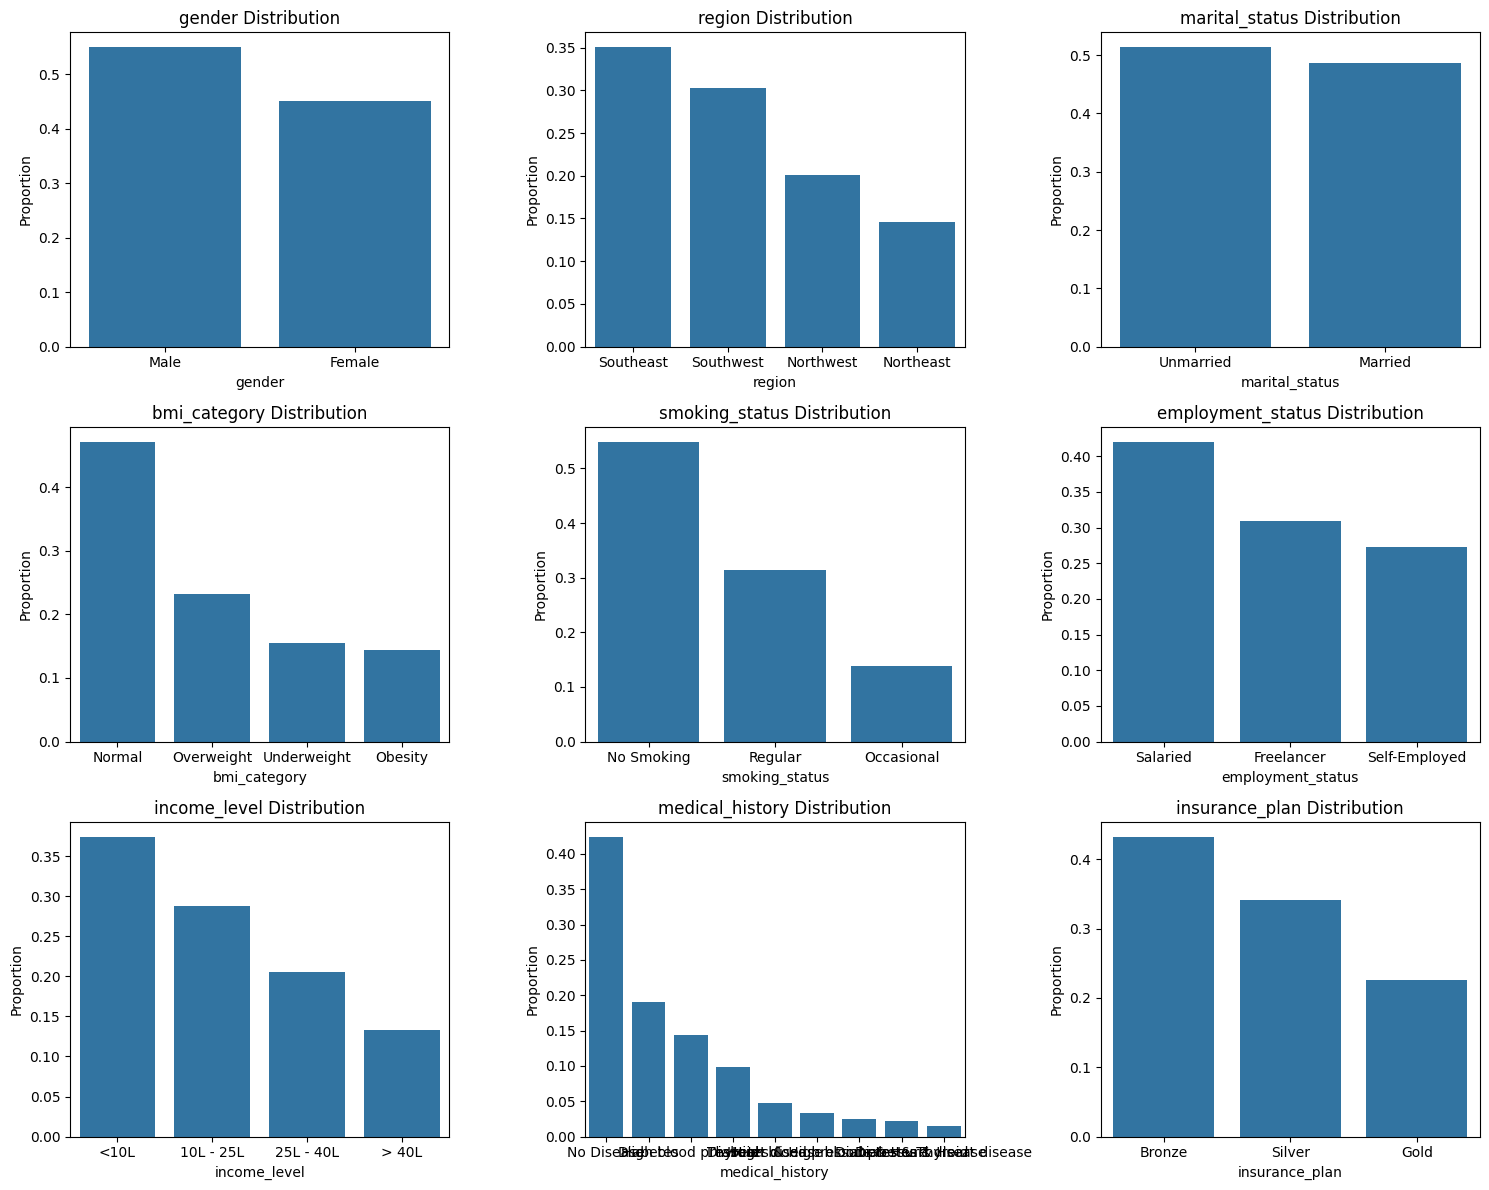

In [37]:
barPlot(df2, categorical_cols)

#### Bivariate Analysis : Categorical columns

In [38]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5307,3880,5182
25L - 40L,3683,2840,3750
<10L,12226,931,5486
> 40L,329,3653,2641


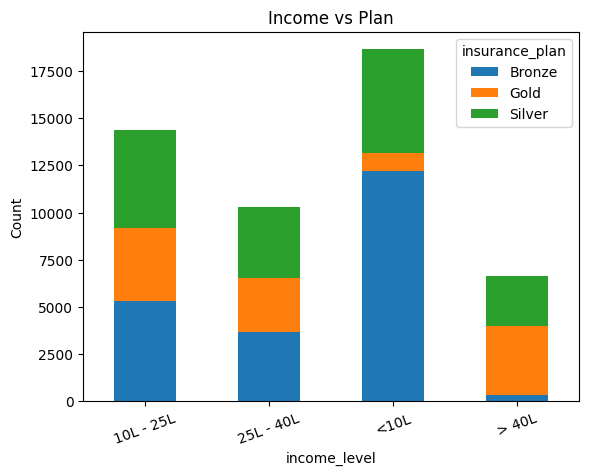

In [39]:
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.xticks(rotation=20)
plt.ylabel('Count')
plt.show()

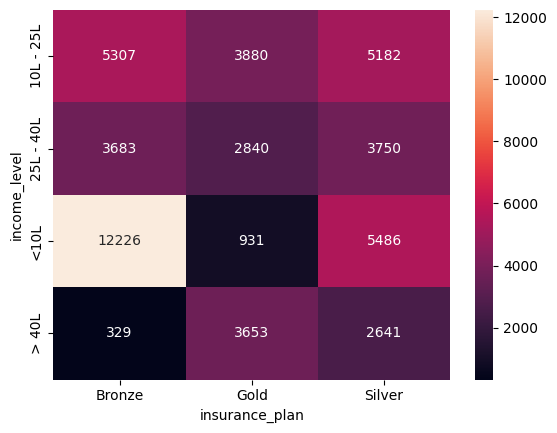

In [40]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.show()

## Feature Engineering

In [41]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [42]:
risk_scores_dictionary = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

In [43]:
df2[['disease1', 'disease2']] = df2.medical_history.str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None


In [44]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

df2.head()

C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_14584\1524846493.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_14584\1524846493.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,0


In [45]:
df2['total_risk_score'] = df2['disease1'].map(risk_scores_dictionary) + df2['disease2'].map(risk_scores_dictionary)

df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6


In [46]:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


In [47]:
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
22936,24,Female,Northeast,Unmarried,1,Normal,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,3632,no disease,none,0,0.000000
22289,35,Female,Southeast,Married,2,Underweight,No Smoking,Salaried,<10L,1,Diabetes & High blood pressure,Bronze,11550,diabetes,high blood pressure,12,0.857143
21923,45,Male,Southeast,Unmarried,1,Underweight,Regular,Salaried,10L - 25L,23,No Disease,Silver,17363,no disease,none,0,0.000000
28678,59,Male,Southwest,Married,3,Overweight,Regular,Freelancer,<10L,3,High blood pressure,Silver,23139,high blood pressure,none,6,0.428571
10546,21,Male,Northwest,Married,3,Underweight,Regular,Freelancer,10L - 25L,22,No Disease,Silver,10121,no disease,none,0,0.000000


In [48]:
insurance_plan_dictionary = {
    'Bronze': 1,
    'Silver': 2,
    'Gold': 3,
}

df2['insurance_plan'] = df2['insurance_plan'].map(insurance_plan_dictionary)

In [49]:
df2['insurance_plan'].unique()

array([1, 2, 3])

In [50]:
income_level_dictionary = {
    '<10L': 1,
    '10L - 25L': 2,
    '25L - 40L': 3,
    '> 40L': 4,
}

df2['income_level'] = df2['income_level'].map(income_level_dictionary)

In [51]:
df2['income_level'].unique()

array([1, 2, 4, 3])

In [52]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [53]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [54]:
cols_to_drop = ['disease1', 'disease2', 'total_risk_score', 'medical_history']

df4 = df3.drop(cols_to_drop, axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Correlation Analysis

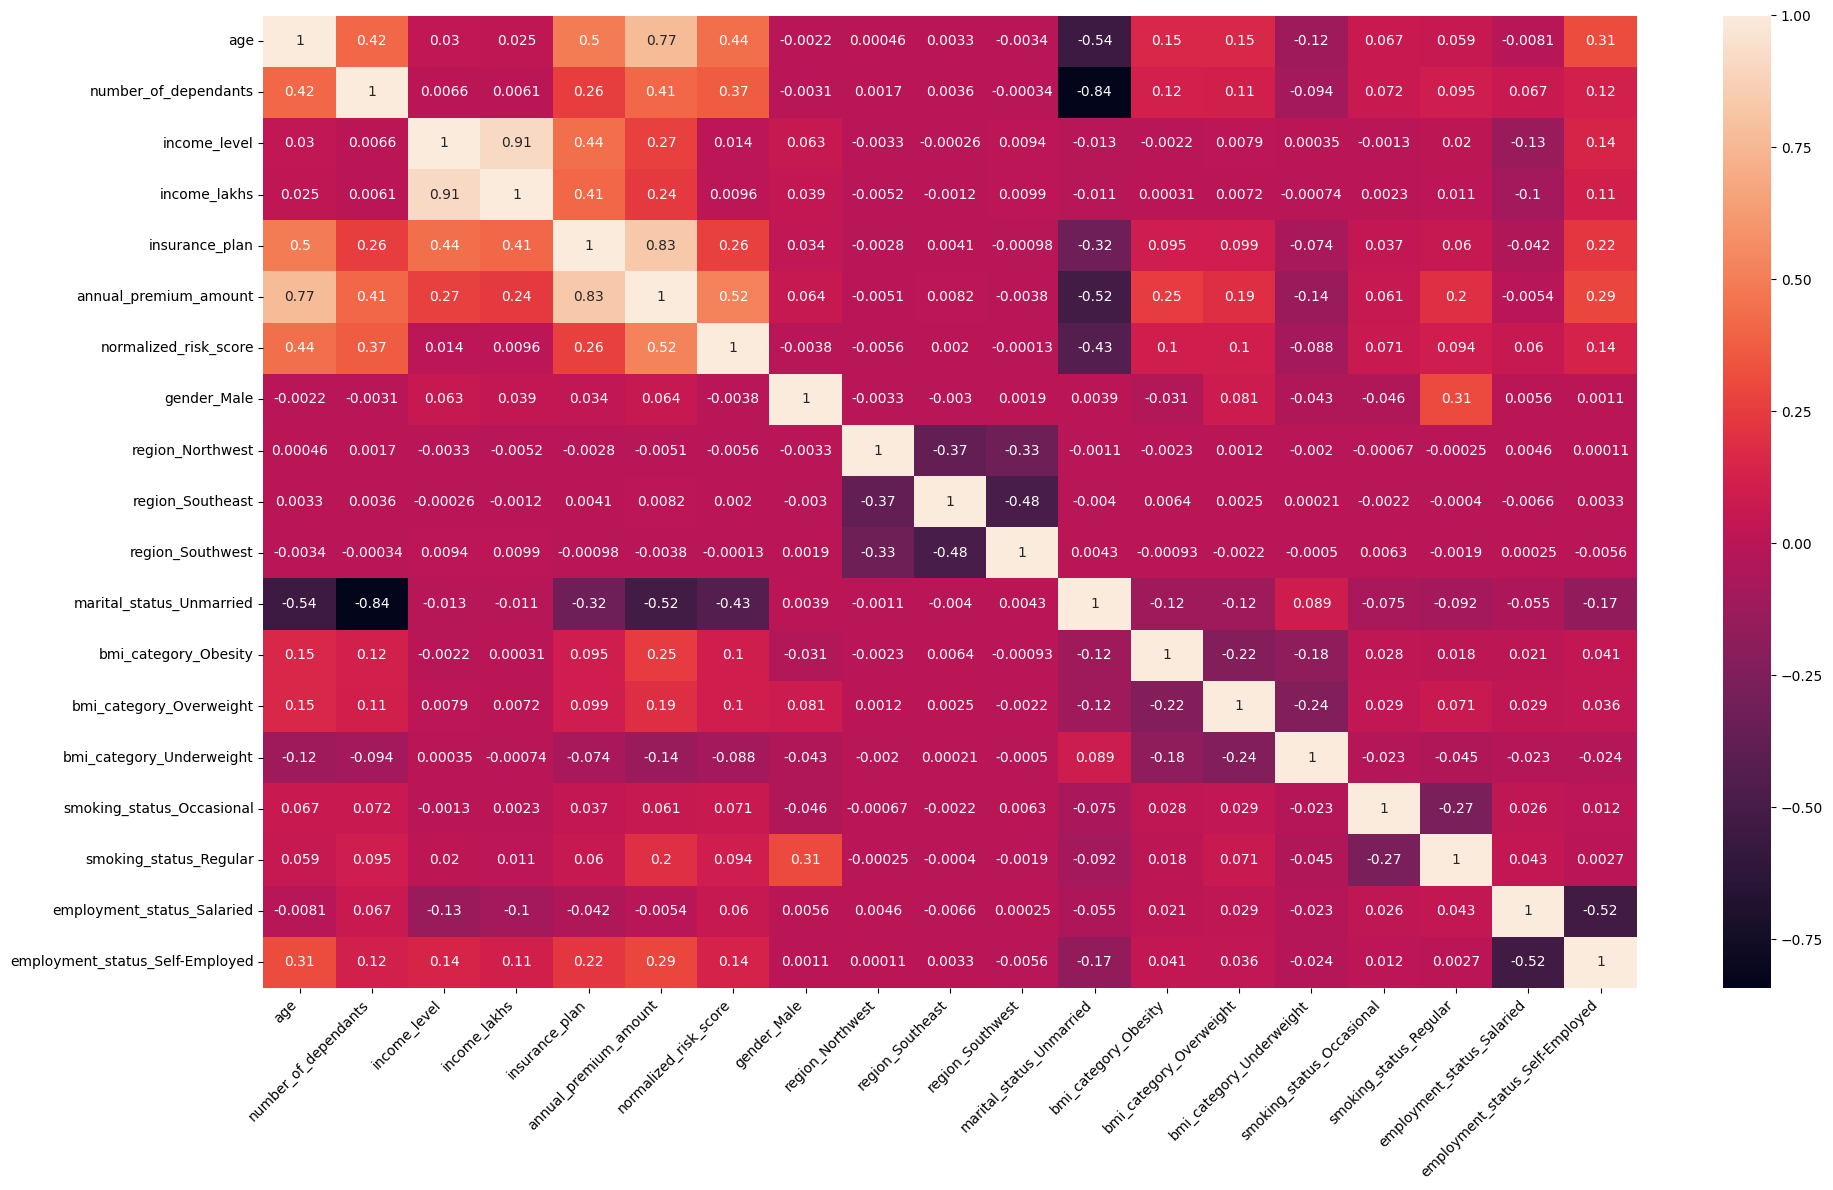

In [55]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

In [56]:
X = df4.drop(target, axis='columns')
y = df4[target]

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [57]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculateVIF(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [59]:
calculateVIF(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [60]:
X = X.drop('income_level', axis='columns')

calculateVIF(X)

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [61]:
X.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


## Model Training

In [62]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)

### Linear Regression

In [63]:
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

LinearRegression()

In [64]:
train_score = model_LR.score(X_train, y_train)
test_score = model_LR.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.9282143576916762
Test data score: 0.9280547230217837


In [65]:
y_pred = model_LR.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 5165611.913027982
Root Mean Squared Error: 2272.798256121291
R2 Score: 0.9224311942762632


In [66]:
X.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [67]:
model_LR.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

In [68]:
model_LR.intercept_

np.float64(4824.300272127104)

In [69]:
feature_importances = model_LR.coef_

coef_df = pd.DataFrame(feature_importances, columns=['Coefficients'], index=X.columns)
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
marital_status_Unmarried,-935.760611
number_of_dependants,-676.443991
income_lakhs,-514.229816
region_Northwest,-35.719292
region_Southwest,-24.652929
region_Southeast,39.965130
employment_status_Salaried,155.984674
gender_Male,168.646662
bmi_category_Underweight,391.171304
employment_status_Self-Employed,415.903973


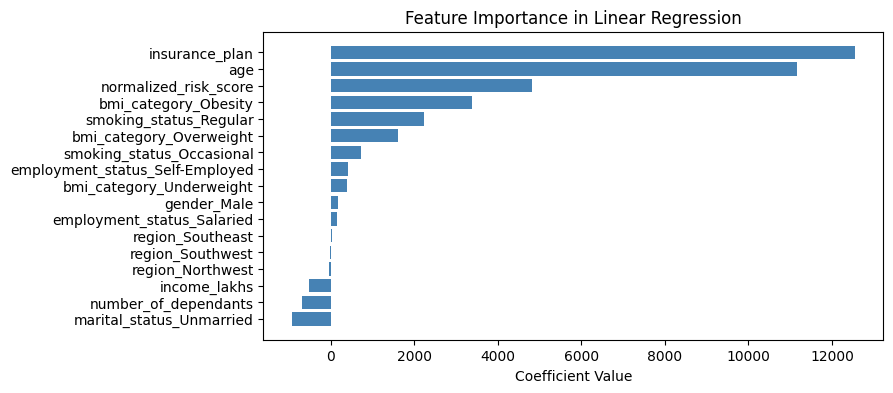

In [70]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df[ 'Coefficients'], color='steelblue') 
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression

In [71]:
model_RG = Ridge()
model_RG.fit(X_train, y_train)

Ridge()

In [72]:
train_score = model_RG.score(X_train, y_train)
test_score = model_RG.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.9282143198366275
Test data score: 0.9280541644640345


In [73]:
y_pred = model_RG.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 5165652.017016523
Root Mean Squared Error: 2272.8070787060924
R2 Score: 0.9224084375178946


### XGBoost

In [74]:
from xgboost import XGBRegressor

model_XGB = XGBRegressor()
model_XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [75]:
train_score = model_XGB.score(X_train, y_train)
test_score = model_XGB.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.9860964417457581
Test data score: 0.9809534549713135


In [76]:
y_pred = model_XGB.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 1367525.625
Root Mean Squared Error: 1169.4125127601467
R2 Score: 0.9806463718414307


In [77]:
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search= RandomizedSearchCV(model_XGB, param_grid, n_iter=10, cv=3, scoring='r2', random_state=4)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9814704656600952)

In [78]:
best_model = random_search.best_estimator_

In [79]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, columns=['Coefficients'], index=X.columns)
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
region_Southeast,0.000000
employment_status_Self-Employed,0.000000
region_Southwest,0.000098
employment_status_Salaried,0.000102
marital_status_Unmarried,0.000111
gender_Male,0.000122
income_lakhs,0.000156
region_Northwest,0.000194
number_of_dependants,0.000325
bmi_category_Underweight,0.001076


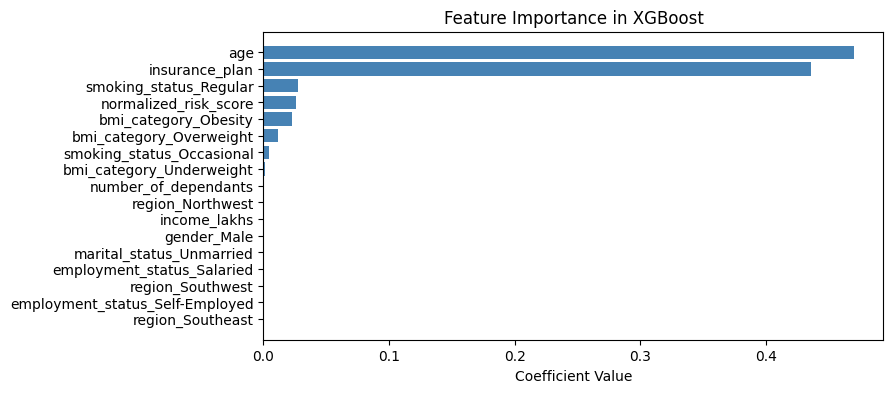

In [83]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df[ 'Coefficients'], color='steelblue') 
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

## Error Analysis

In [84]:
y_pred = best_model.predict(X_test)

In [86]:
residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

In [87]:
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct,
})
results_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20481.802734,-72.197266,-0.351257
35794,29647,29399.103516,-247.896484,-0.836160
43608,20560,20621.814453,61.814453,0.300654
42730,5018,7402.557129,2384.557129,47.520070
18936,8929,8295.146484,-633.853516,-7.098819


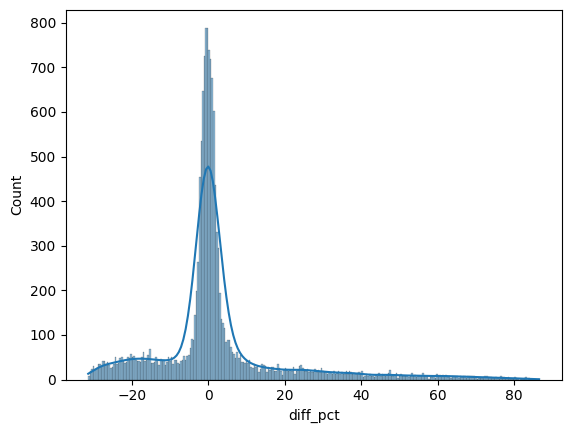

In [88]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.show()

In [93]:
threshold_margin_of_error = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct) > threshold_margin_of_error]

In [100]:
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
print(f'Number of rows in results : {results_df.shape[0]}')
print(f'Number of rows in extreme error : {extreme_results_df.shape[0]}')
print(f'Percentage: {extreme_errors_pct}')

Number of rows in results : 14973
Number of rows in extreme error : 4445
Percentage: 29.686769518466573


In [101]:
results_df[np.abs(results_df.diff_pct) > threshold_margin_of_error].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct
36269,3501,6529.937012,3028.937012,86.516339
42342,3521,6529.937012,3008.937012,85.456888
18564,3523,6529.937012,3006.937012,85.351604
48801,3516,6512.600098,2996.600098,85.227534
7988,3527,6512.600098,2985.600098,84.649847
...,...,...,...,...
6690,9456,6512.600098,-2943.399902,-31.127326
1826,9491,6529.937012,-2961.062988,-31.198641
7149,9488,6512.600098,-2975.399902,-31.359611
78,9490,6512.600098,-2977.399902,-31.374077


In [105]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(5)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


In [116]:
import math

def compareHistPlot(data1, data2, cols):
    num_cols = len(cols)
    rows = math.ceil(num_cols / 3)  # Max 3 charts per row
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, col in enumerate(cols):
        sns.histplot(data1[col], kde=True, label='Overall', color='blue', ax=axes[i])
        sns.histplot(data2[col], kde=True, label='Errors', alpha=0.5, color='red', ax=axes[i])
        axes[i].legend()
        axes[i].set_title(f'Distribution of {col} for Errors vs Overall')

    # Hide unused subplots (if any)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

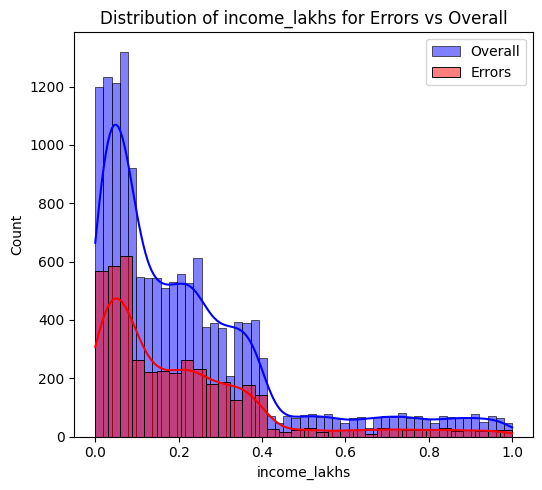

In [117]:
compareHistPlot(X_test, extreme_errors_df, ['income_lakhs'])

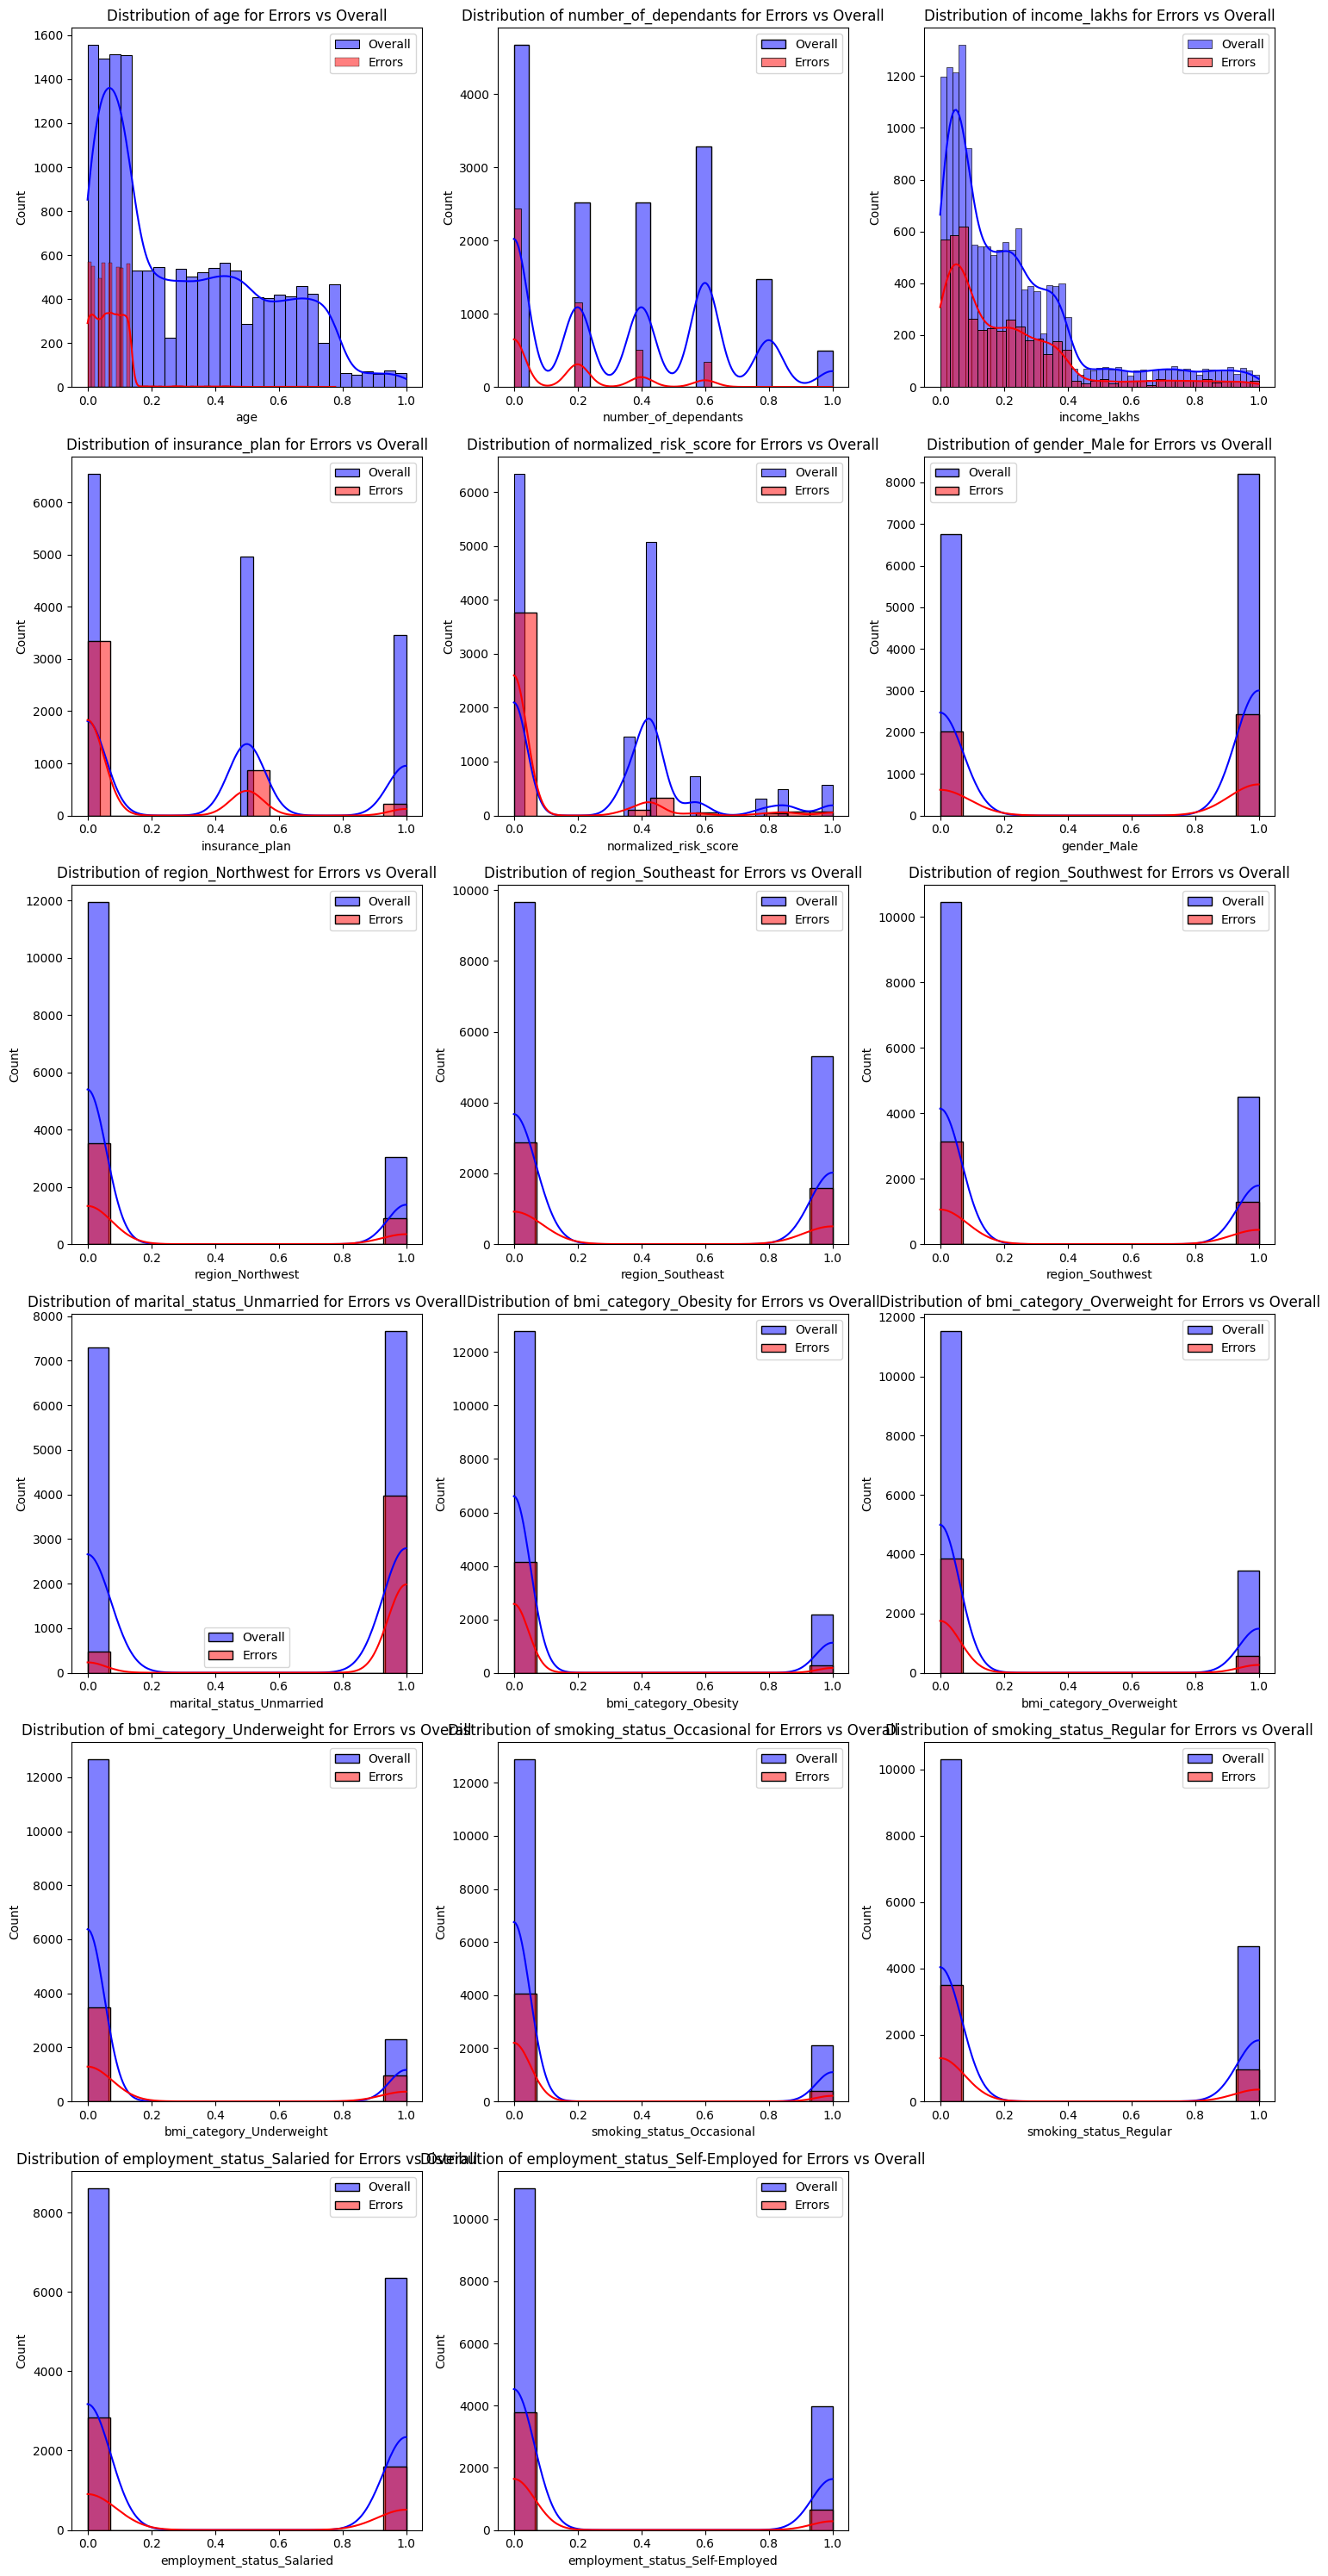

In [118]:
compareHistPlot(X_test, extreme_errors_df, X.columns)

In [119]:
extreme_errors_df['income_level'] = -1

In [122]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0
...,...,...,...,...,...
4440,19.0,1.0,-2.0,8.0,1.0
4441,25.0,0.0,-2.0,12.0,1.0
4442,21.0,0.0,-2.0,7.0,2.0
4443,21.0,1.0,-2.0,8.0,1.0


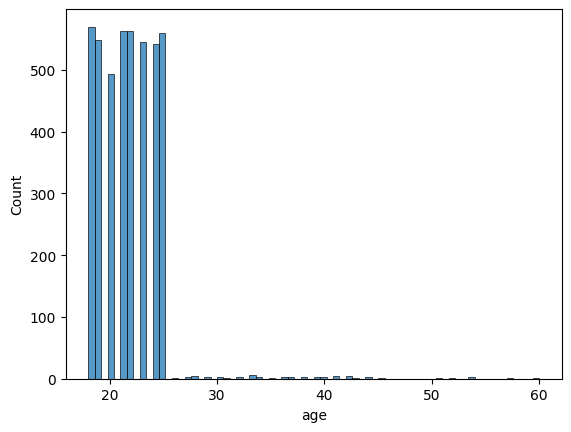

In [123]:
sns.histplot(df_reversed, x='age')
plt.show()

In [131]:
df_reversed['age'].quantile(0.98)

np.float64(25.0)